In [1]:
from __future__ import print_function
import argparse
import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


import numpy as np 
import pandas as pd
from PIL import Image
import time
import glob
import imageio
import cv2
import pathlib
import zipfile
import sys
import pandas as pd 

import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import MNIST

from skimage import io, transform

from IPython import display
from IPython.display import HTML
manualSeed = 999
#Needed for introducing noise
random.seed(manualSeed) 
torch.manual_seed(manualSeed)

In [2]:
!pip install graphviz
!pip install torchsummary
! pip install torchview
from torchsummary import summary
import torchvision
from torchview import draw_graph

In [3]:
# Set the root directory for the dataset
dataroot = "./selected_slices"

# Number of worker threads for loading the data (2 workers for parallelism)
workers = 2

# Specify the batch size for training (number of samples per batch)
batch_size = 128

# Define the size of each image (assuming square dimensions of 128x128 pixels)
image_size = 128

# Specify the number of color channels (1 for grayscale images)
nc = 1

# Define the dimensionality of the latent vector (input to the generator)
nz = 100

# Define the number of generator filters in the last convolutional layer
ngf = image_size

# Define the number of discriminator filters in the first convolutional layer
ndf = image_size

# Specify the number of GPUs to use for computation (1 means using a single GPU)
ngpu = 1

In [4]:
def seed_worker(worker_id):
    """
    Set the seed for a data loader worker to ensure reproducibility.

    Args:
        worker_id (int): The ID of the worker thread.

    Steps:
        1. Retrieve the initial seed generated by PyTorch for the worker.
        2. Use modulo operation with 2**32 to ensure the seed is within the valid range for random number generation.
        3. Set the seed for NumPy's random generator using the worker-specific seed.
        4. Set the seed for Python's random module using the same worker-specific seed.
    """
    # Retrieve the initial seed and ensure it is within the range of 32-bit unsigned integers
    worker_seed = torch.initial_seed() % 2**32

    # Set the seed for NumPy's random number generator
    np.random.seed(worker_seed)

    # Set the seed for Python's random number generator
    random.seed(worker_seed)

In [5]:
# Create the dataset from the specified root directory using ImageFolder
# Apply a series of transformations to the images:
# 1. Convert images to grayscale
# 2. Resize images to the specified dimensions (image_size x image_size)
# 3. Convert images to PyTorch tensors
# 4. Normalize pixel values to the range [-1, 1] using mean=0.5 and std=0.5
dataset = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Grayscale(),                       # Convert images to grayscale
        transforms.Resize((image_size, image_size)),  # Resize images to specified size
        transforms.ToTensor(),                        # Convert images to tensors
        transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize pixel values to [-1, 1]
    ])
)

# Create a DataLoader for the dataset to manage batching, shuffling, and multi-threaded loading
# Arguments:
# - batch_size: Number of samples per batch
# - shuffle: Randomize the order of samples
# - num_workers: Number of subprocesses to use for data loading
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

# Set the device for computation:
# - Use GPU (CUDA) if available and ngpu > 0
# - Otherwise, use CPU
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


In [6]:
import torch
import torch.nn as nn
from torchsummary import summary

# Define the Generator class, which generates fake images from random noise
class Generator(nn.Module):
    """
    A model that generates fake images using transposed convolutions.
    The generator takes a latent vector (noise) and progressively upscales it 
    to the desired image size.
    """
    def __init__ (self, z_dim=100, img_channels=1, features_g=32):
        """
        Initialize the Generator.

        Args:
            z_dim (int): Dimensionality of the latent vector (noise input).
            img_channels (int): Number of channels in the output image (1 for grayscale).
            features_g (int): Base number of feature maps in the generator.
        """
        super (Generator, self).__init__ ()
        


        # Define the generator's network as a sequence of transposed convolutional blocks
        # Input: N x z_dim x 1 x 1 (latent vector)
        self.gen = nn.Sequential(
            # Block 1: Upscale to 4x4
            self._block(z_dim, features_g * 32, 4, 2, 0),  # Output: features_g*32 x 4 x 4

            # Block 2: Upscale to 8x8
            self._block(features_g * 32, features_g * 16, 4, 2, 1),  # Output: features_g*16 x 8 x 8

            # Block 3: Upscale to 16x16
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # Output: features_g*8 x 16 x 16

            # Block 4: Upscale to 32x32
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # Output: features_g*4 x 32 x 32

            # Block 5: Upscale to 64x64
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # Output: features_g*2 x 64 x 64

            # Final Block: Upscale to 128x128
            nn.ConvTranspose2d(
                features_g * 2, img_channels, kernel_size=4, stride=2, padding=1
            ),  # Output: img_channels x 128 x 128

            # Apply Tanh activation to scale output pixel values to [-1, 1]
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        """
        Helper function to create a transposed convolutional block.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int): Size of the convolutional kernel.
            stride (int): Stride of the convolution.
            padding (int): Padding added to each side of the input.

        Returns:
            nn.Sequential: A block containing ConvTranspose2d, BatchNorm2d, and ReLU.
        """
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),  # Normalize feature maps
            nn.ReLU()  # Apply ReLU activation
        )

    def forward(self, x):
        """
        Forward pass of the generator.

        Args:
            x (torch.Tensor): Input latent vector of shape (N, z_dim, 1, 1).

        Returns:
            torch.Tensor: Generated images of shape (N, img_channels, 128, 128).
        """
        return self.gen(x)

# Print a summary of the Generator's architecture
summary(Generator().to(device), (nz, 1, 1))

# Print the Generator's structure for debugging
print(Generator(z_dim=nz, img_channels=1, features_g=32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [7]:
##########################
### MODEL
##########################

import torch.nn.functional as F

class Critic(torch.nn.Module):

    def __init__(self, num_classes=2):
        super(Critic, self).__init__()
        
        #########################
        ### 1st residual block
        #########################
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_1_bn = torch.nn.InstanceNorm2d(4)
                                    
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)   
        self.conv_2_bn = torch.nn.InstanceNorm2d(8)
        
        self.conv_shortcut_1 = torch.nn.Conv2d(in_channels=1,
                                               out_channels=8,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)   
        self.conv_shortcut_1_bn = torch.nn.InstanceNorm2d(8)
        
        #########################
        ### 2nd residual block
        #########################
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_3_bn = torch.nn.InstanceNorm2d(16)
                                    
        # 7x7x16 => 7x7x32
        self.conv_4 = torch.nn.Conv2d(in_channels=16,
                                      out_channels=32,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)   
        self.conv_4_bn = torch.nn.InstanceNorm2d(32)
        
        # 14x14x8 => 7x7x32 
        self.conv_shortcut_2 = torch.nn.Conv2d(in_channels=8,
                                               out_channels=32,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)   
        self.conv_shortcut_2_bn = torch.nn.InstanceNorm2d(32)
        
        #########################
        ### 3nd residual block
        #########################
        self.conv_5 = torch.nn.Conv2d(in_channels=32,
                                      out_channels=64,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_5_bn = torch.nn.InstanceNorm2d(64)
                                    
        self.conv_6 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=128,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)   
        self.conv_6_bn = torch.nn.InstanceNorm2d(128)
        
        self.conv_shortcut_3 = torch.nn.Conv2d(in_channels=32,
                                               out_channels=128,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)   
        self.conv_shortcut_3_bn = torch.nn.InstanceNorm2d(128)

        
        #########################
        ### Fully connected
        ######################### 
        self.flat=nn.Flatten()
        
        self.linear_1 = torch.nn.Linear(16*16*128, num_classes)
        self.final=nn.Sigmoid()
            

    
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        # self.relu = nn.ReLU()
        
    def forward(self, x):
        
        #########################
        ### 1st residual block
        #########################
        shortcut = x
        
        out = self.conv_1(x) # 28x28x1 => 14x14x4 
        out = self.conv_1_bn(out)
        out = self.relu(out)

        out = self.conv_2(out) # 14x14x4 => 714x14x8
        out = self.conv_2_bn(out)
        
        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_1(shortcut)
        shortcut = self.conv_shortcut_1_bn(shortcut)
        
        out += shortcut
        out = self.relu(out)
        
        #########################
        ### 2nd residual block
        #########################
        
        shortcut = out
        
        out = self.conv_3(out) 
        out = self.conv_3_bn(out)
        out = F.relu(out)

        out = self.conv_4(out) 
        out = self.conv_4_bn(out)
        
        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_2(shortcut)
        shortcut = self.conv_shortcut_2_bn(shortcut)
        
        out += shortcut
        out = self.relu(out)
         
        #########################
        ### 3rd residual block
        #########################
        
        shortcut = out
        
        out = self.conv_5(out) 
        out = self.conv_5_bn(out)
        out = self.relu(out)

        out = self.conv_6(out)
        out = self.conv_6_bn(out)
        
        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_3(shortcut)
        shortcut = self.conv_shortcut_3_bn(shortcut)
        
        out += shortcut
        out = self.relu(out)
        
        #########################
        ### Fully connected
        ######################### 
        out=self.flat(out)
        out = self.linear_1(out)
        out=self.final(out)
        
        return out


    
model = Critic()
model = model.to(device)

In [8]:
def get_noise(n_samples, nz, device='cpu'):
    """
    Generates random noise vectors to be used as input for the Generator.

    Args:
        n_samples (int): The number of noise vectors to generate (batch size).
        nz (int): The dimensionality of the latent vector (noise vector size).
        device (str): The device to create the noise on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: A tensor of shape (n_samples, nz, 1, 1) containing random noise 
                      sampled from a standard normal distribution.
    """
    return torch.randn(n_samples, nz, 1, 1, device=device)

In [9]:
fixed_noise = get_noise(batch_size, nz, device=device)

In [10]:
fixed_noise.shape

torch.Size([128, 100, 1, 1])

Time is 2.3724989891052246 sec
Shape of loading one batch: torch.Size([128, 1, 128, 128])
Total no. of batches present in trainloader: 5


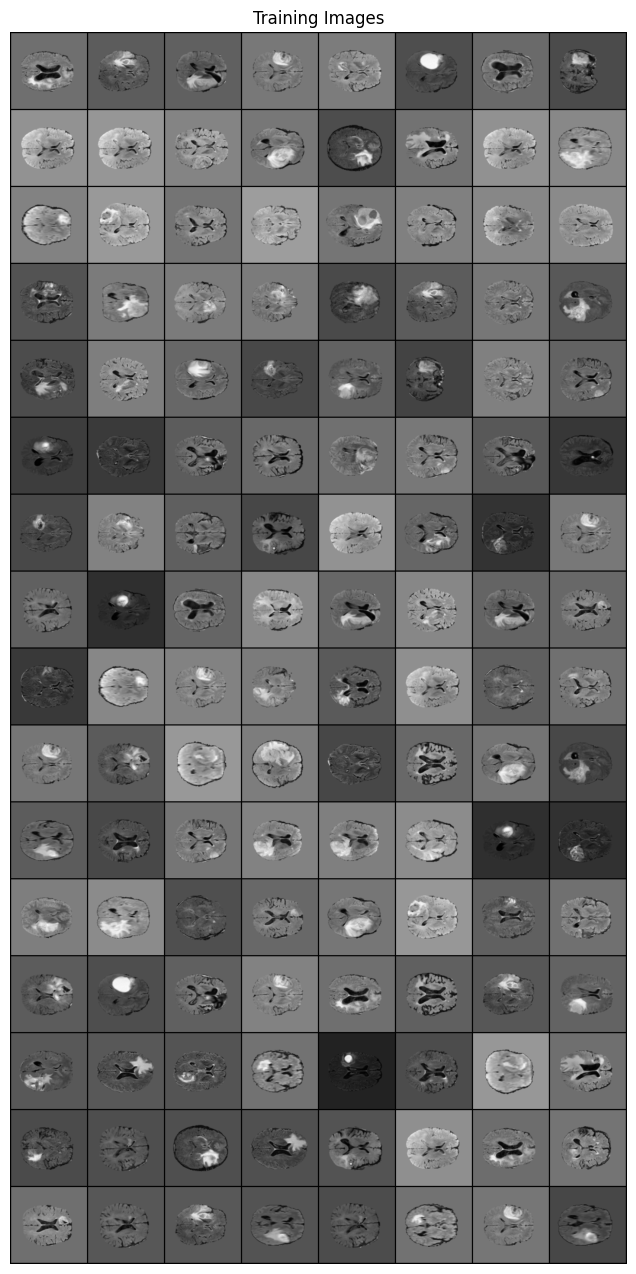

In [11]:
# Record the start time for loading a batch of data
start = time.time()

# Get the next batch of images and labels from the DataLoader
dataiter = iter(dataloader)
images, labels = dataiter.__next__()

# Print the time taken to load one batch of data
print('Time is {} sec'.format(time.time() - start))

# Plot the batch of training images
plt.figure(figsize=(16, 16))  # Set the figure size
plt.axis("off")  # Remove axes for better visualization
plt.title("Training Images")  # Set title for the plot

# Display the images in a grid format after normalizing and moving to CPU
plt.imshow(np.transpose(
    make_grid(images.to(device), padding=2, normalize=True).cpu(),
    (1, 2, 0)
))

# Print the shape of one batch of images
print('Shape of loading one batch:', images.shape)

# Print the total number of batches in the DataLoader
print('Total no. of batches present in trainloader:', len(dataloader))


In [12]:
def gradient_penalty(gradient):
    """
    Calculates the gradient penalty for WGAN-GP.
    Ensures the gradient norm is close to 1 for stable training.
    """
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty


def get_gen_loss(crit_fake_pred):
    """
    Generator loss: maximize the critic's prediction for fake samples (minimize the negative mean).
    """
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss


def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    """
    Critic loss: maximize the difference between real and fake predictions, 
    with a gradient penalty term to enforce Lipschitz constraint.
    """
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

def get_gradient(crit, real, fake, epsilon):
    """
    Compute the gradient of critic scores with respect to mixed images,
    used for gradient penalty computation.
    """
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = crit(mixed_images)
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
        
    )[0]
    return gradient

In [13]:
# Learning rates for the generator and critic
lr_g = 0.0002  # Generator learning rate
lr_c = 0.0002  # Critic learning rate

# Hyperparameters for the Adam/RMSprop optimizer
beta_1 = 0.0  # First moment decay rate
beta_2 = 0.999  # Second moment decay rate

def weights_init(m):
    """
    Initialize weights for convolutional and batch normalization layers:
    - Convolutional layers: Weights are initialized from a normal distribution with mean 0 and std 0.02.
    - BatchNorm layers: Weights are initialized with mean 1 and std 0.02; biases are set to 0.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Binary Cross-Entropy Loss, though typically unused in WGAN-GP setups
criterion = nn.BCELoss()

# Initialize the Generator and move it to the specified device
gen = Generator().to(device)

# Enable multi-GPU training for the Generator if applicable
if (device.type == 'cuda') and (ngpu > 1):
    gen = nn.DataParallel(gen, list(range(ngpu)))
# Initialize the Critic and move it to the specified device
crit = Critic().to(device) 

# Enable multi-GPU training for the Critic if applicable
if (device.type == 'cuda') and (ngpu > 1):
    crit = nn.DataParallel(crit, list(range(ngpu)))

# Optimizers for the generator and critic using RMSprop
gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lr_g)
crit_opt = torch.optim.RMSprop(crit.parameters(), lr=lr_c)

# Apply weight initialization to both Generator and Critic
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [14]:
def show_tensor_images(image_tensor, num_images=25, size=(nc, image_size, image_size), show_fig=False, epoch=0):
    """
    Displays or saves a grid of images from a tensor.

    Args:
        image_tensor (torch.Tensor): Tensor of images to display (e.g., output from Generator).
        num_images (int): Number of images to display in the grid.
        size (tuple): Shape of each image (channels, height, width).
        show_fig (bool): If True, saves the grid as a PNG file.
        epoch (int): Epoch number, used in the filename when saving images.

    Steps:
        1. Detach and move the tensor to the CPU, reshape into the image size.
        2. Create a grid of images using `make_grid`.
        3. Display the grid using Matplotlib.
        4. Optionally save the grid as an image file.
    """
    # Detach tensor, move to CPU, and reshape into specified size
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    
    # Create a grid of images from the unflattened tensor
    image_grid = make_grid(image_unflat[:num_images], nrow=5,normalize=True)
    
    # Remove axes and display the image grid
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())  # Rearrange dimensions for visualization
    
    # Save the image grid to a file if `show_fig` is True
    if show_fig:
        plt.savefig('./gez_images_256_2/image_at_epoch_{:04d}.png'.format(epoch))


Epoch: 0/1000 Steps:5/5	Epoch_Run_Time: 6.899987	Loss_C : 9.998586	Loss_G : -0.500000		
Epoch: 0/1000 Total Steps:5	Total_Time : 7.225085	Loss_C : 9.998586	Loss_G : -0.500000	Loss_C_Mean : 12.856151	Loss_G_Mean : -0.500000	
Epoch: 1/1000 Steps:5/5	Epoch_Run_Time: 6.622027	Loss_C : 9.999212	Loss_G : -0.500000	
Epoch: 1/1000 Total Steps:10	Total_Time : 14.266761	Loss_C : 9.999212	Loss_G : -0.500000	Loss_C_Mean : 9.427358	Loss_G_Mean : -0.593007	
Epoch: 2/1000 Steps:5/5	Epoch_Run_Time: 6.583689	Loss_C : 9.998994	Loss_G : -0.500000	
Epoch: 2/1000 Total Steps:15	Total_Time : 21.283631	Loss_C : 9.998994	Loss_G : -0.500000	Loss_C_Mean : 9.998269	Loss_G_Mean : -0.500000	
Epoch: 3/1000 Steps:5/5	Epoch_Run_Time: 6.532677	Loss_C : 9.992279	Loss_G : -0.500000	
Epoch: 3/1000 Total Steps:20	Total_Time : 28.270574	Loss_C : 9.992279	Loss_G : -0.500000	Loss_C_Mean : 9.993241	Loss_G_Mean : -0.500000	
Epoch: 4/1000 Steps:5/5	Epoch_Run_Time: 6.544291	Loss_C : 9.678950	Loss_G : -0.500000	
Epoch: 4/1000 Tot

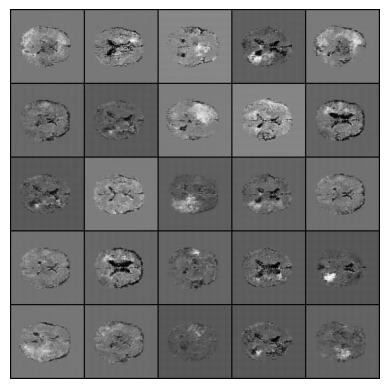

In [15]:
# Training parameters
n_epochs = 1000
cur_step = 0
total_steps = 0
start_time = time.time()
cur_step = 0

# Track losses and mean losses
generator_losses = []
critic_losses = []
C_mean_losses = []  # Critic mean losses per epoch
G_mean_losses = []  # Generator mean losses per epoch

# Hyperparameters for WGAN-GP
c_lambda = 10       # Gradient penalty coefficient
crit_repeats = 5    # Number of critic updates per generator update
display_step = 50   # Frequency of visualization updates

# To store generated images for visualization
img_list = []
iters = 0

# Training loop
for epoch in range(n_epochs):
    cur_step = 0
    start = time.time()
    i=0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, nz, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, nz, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]
        
        cur_step += 1
        total_steps += 1
        
        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(dataloader)}\t"
        print_val += f"Epoch_Run_Time: {(time.time()-start):.6f}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t"  
        print(print_val, end='\r',flush = True)
        
                
        
        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        i+=1
       


        # Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print()
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

    print()
    gen_mean = sum(generator_losses[-cur_step:]) / cur_step
    crit_mean = sum(critic_losses[-cur_step:]) / cur_step
    
    C_mean_losses.append(crit_mean)
    G_mean_losses.append(gen_mean)
    
    print_val = f"Epoch: {epoch}/{n_epochs} Total Steps:{total_steps}\t"
    print_val += f"Total_Time : {(time.time() - start_time):.6f}\t"
    print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
    print_val += f"Loss_G : {gen_loss:.6f}\t"
    print_val += f"Loss_C_Mean : {crit_mean:.6f}\t"
    print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
    print(print_val)
    
    fake_noise = fixed_noise
    fake = gen(fake_noise)
    
    show_tensor_images(fake, show_fig=True,epoch=epoch)
    
    cur_step = 0

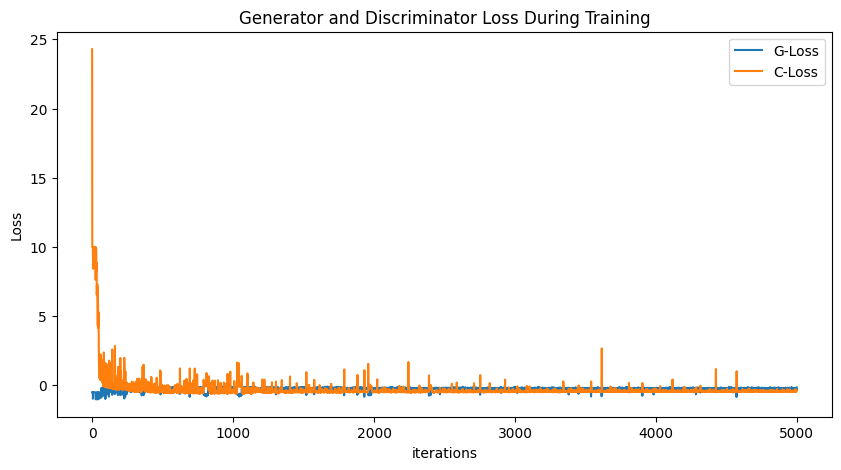

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="G-Loss")
plt.plot(critic_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

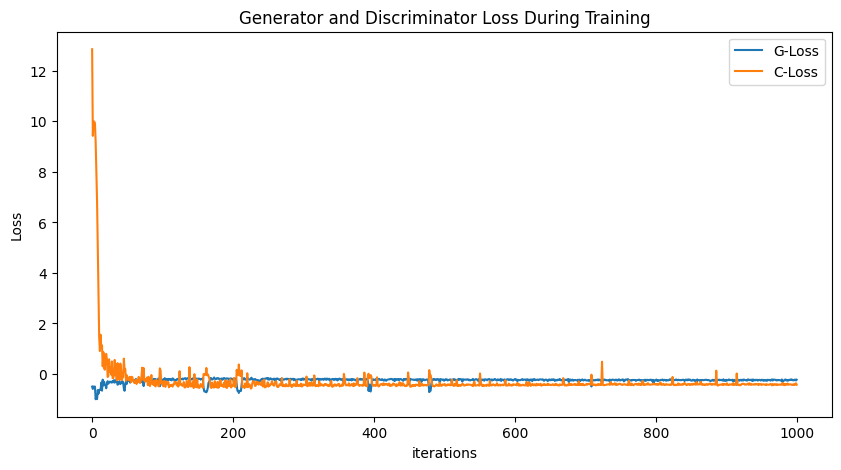

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_mean_losses,label="G-Loss")
plt.plot(C_mean_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

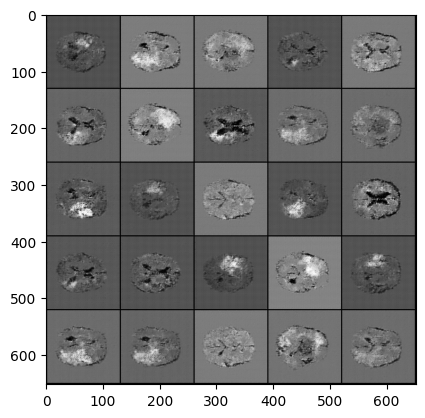

In [18]:
def show_new_gen_images(tensor_img, num_img=25):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze(),cmap='gray')
    plt.show()

num_image = 25
noise = get_noise(num_image, nz, device=device)
with torch.no_grad():
    fake_img = gen(noise)

show_new_gen_images(fake_img.reshape(num_image,nc,image_size,image_size))

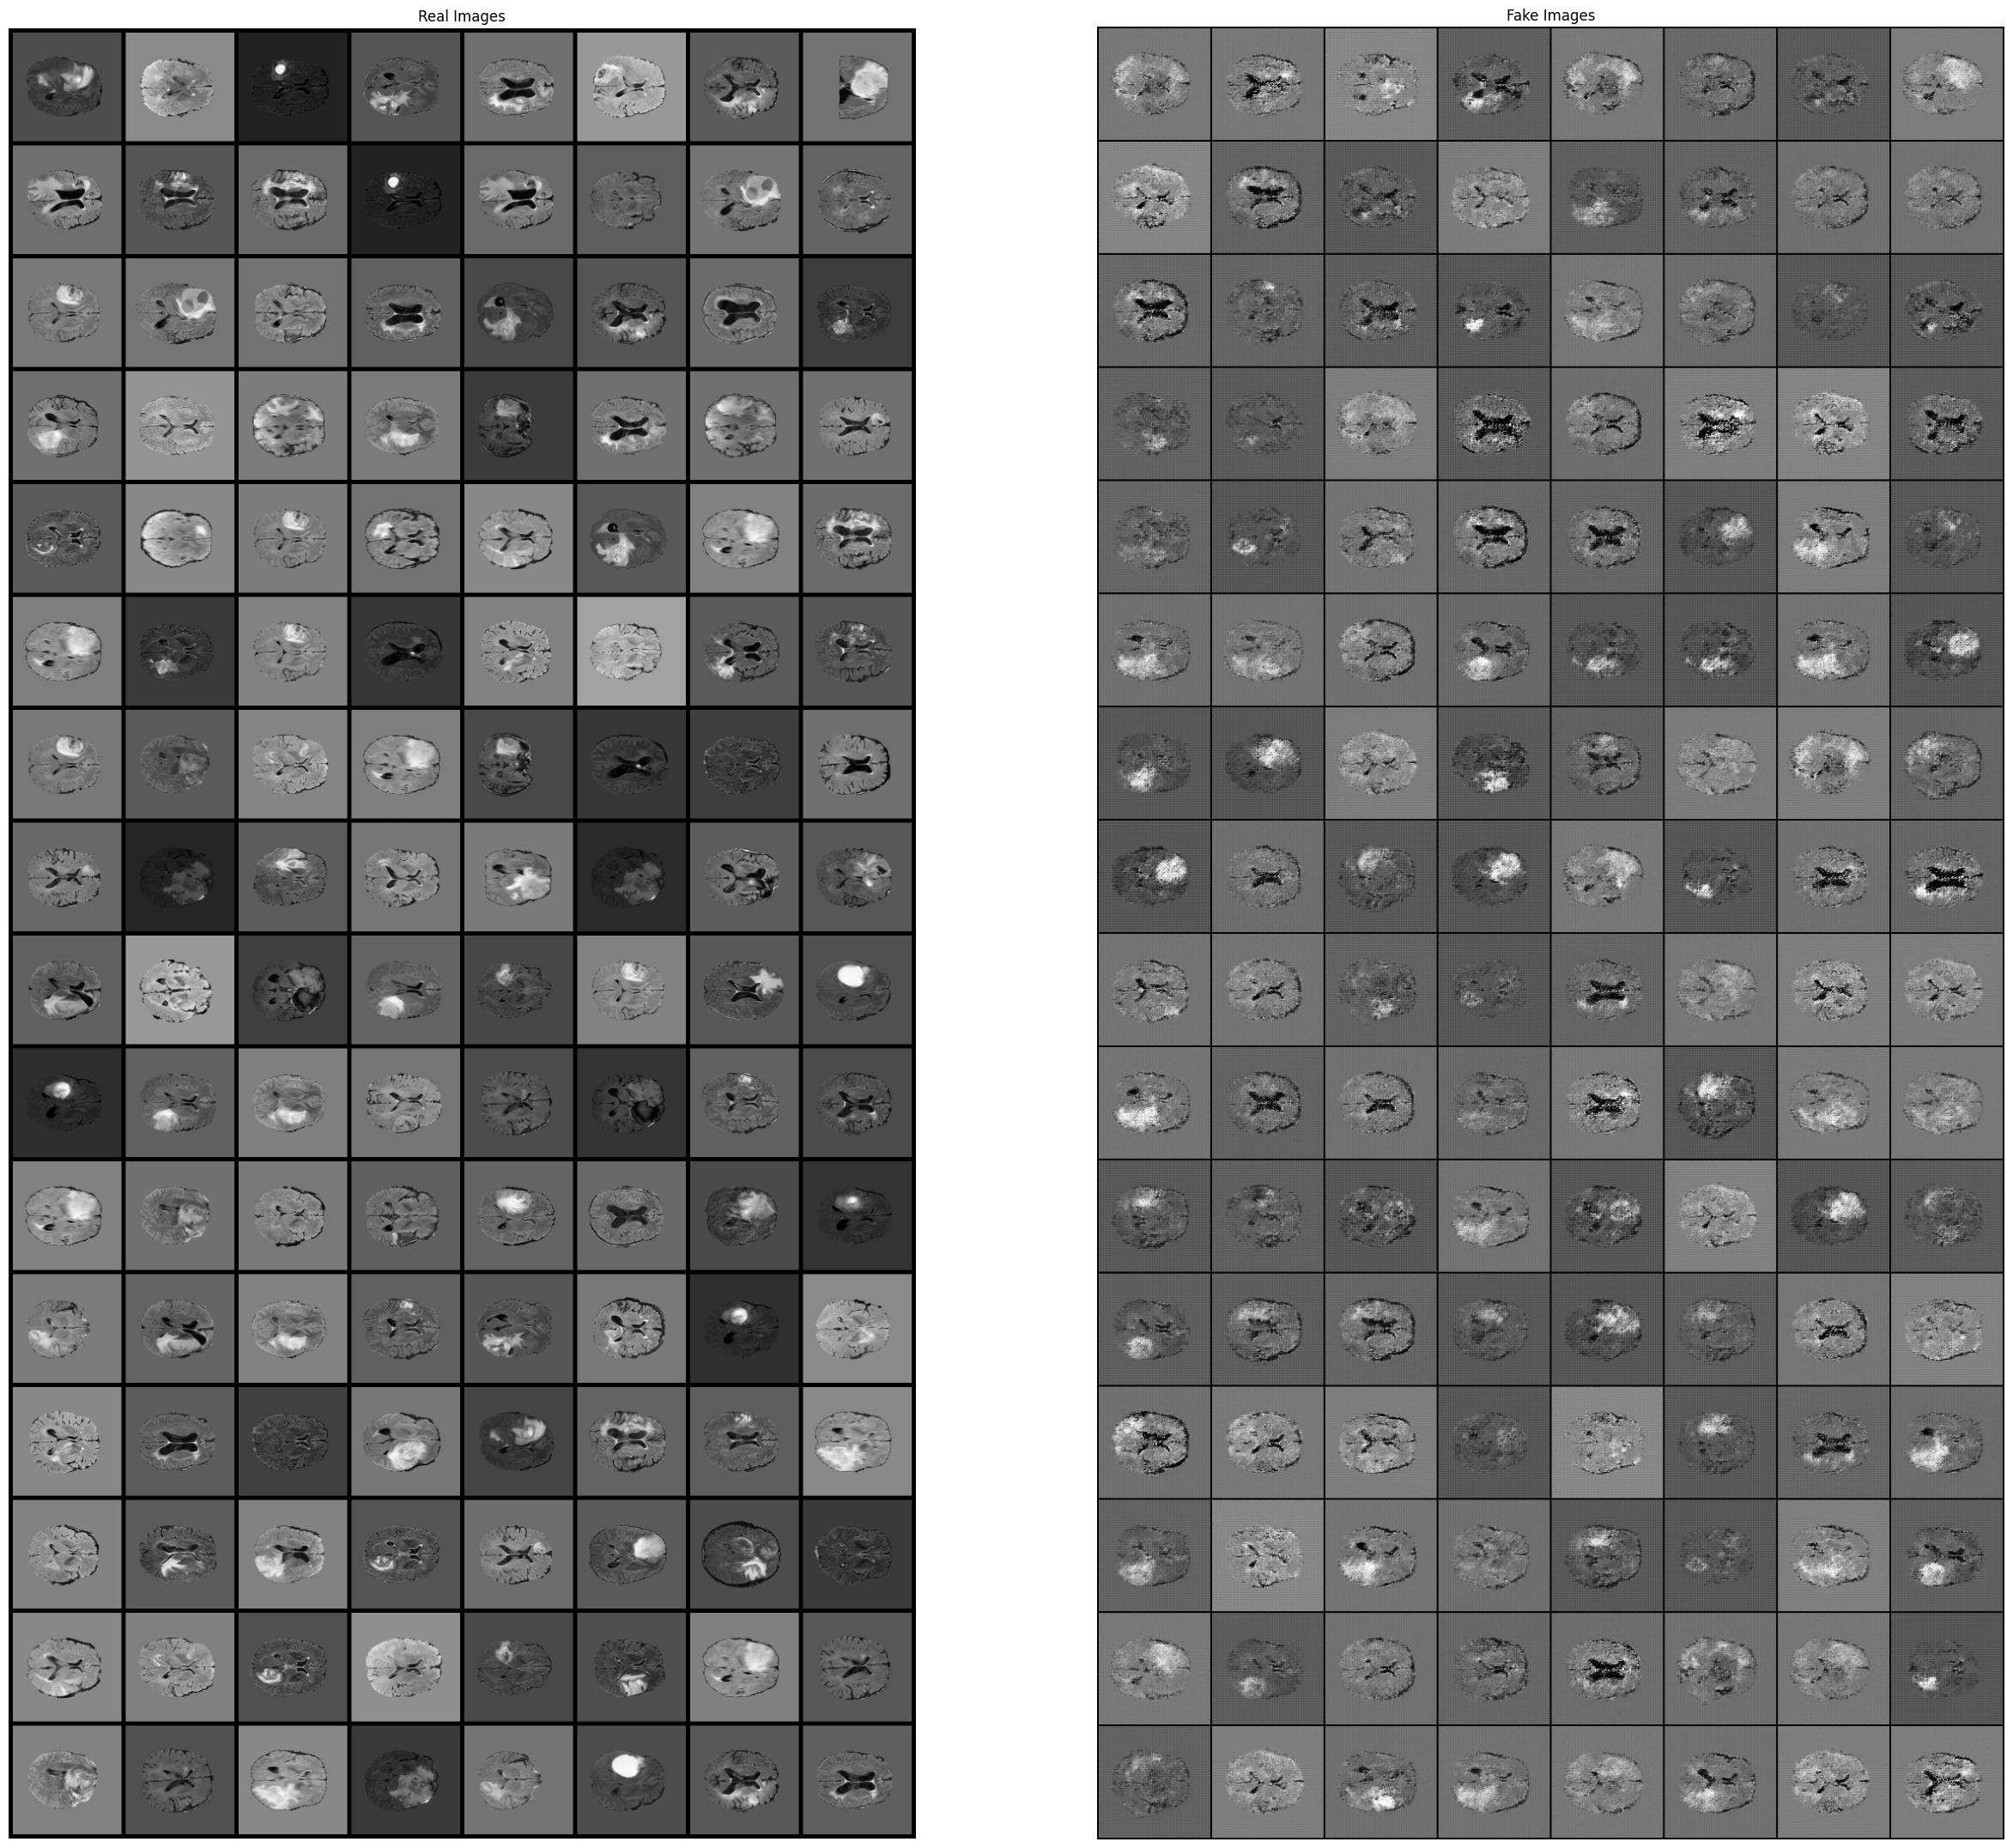

In [19]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('compare.png',dpi=300)
plt.show()